# Wie hoch ist der Anteil an publizierenden Frauen bei den Verlagen Cotta, Insel und Rotbuch?

Dieses Notebook analysiert den Anteil von publizierenden Frauen in den Verlagen Cotta, Insel und Rotbuch anhand der Katalogdaten des DLA Marbach.

Dieser komplexe Lösungsansatz lädt mehrschrittig Titel- und Normdaten und analysiert dann lokal.

In [1]:
# Bibliotheken importieren
import requests
import pandas as pd
import matplotlib.pyplot as plt

Die Publikationen der jeweiligen Verlage (Cotta, Insel, Rotbuch) können mit einer Suche im Feld `publisher_display_mv` ermittelt werden. Die so ermittelten Publikationsdatensätze beinhalten die IDs der Personendatensätze im Feld `personBy_id_mv` und die jeweilige zugehörige Rolle im gleichen Index in `personBy_role_mv`.

In [2]:
# Daten für die drei Verlage abfragen
BASE_URL = "https://dataservice.dla-marbach.de/v1/records"
verlage = ["Cotta", "Insel", "Rotbuch"]
publikationen = {}
for verlag in verlage:
    params = {
        "q": f"publisher_display_mv:{verlag}",
        "fields": "publisher_display_mv,personBy_id_mv,personBy_role_mv"
    }
    r = requests.get(BASE_URL, params=params)
    publikationen[verlag] = pd.DataFrame(r.json())

 Es sollen nur Personen gezählt werden mit personBy_role_mv = `Verfasser` oder `Verfasser/Urheber`.

In [3]:
# Personen-IDs mit Rolle "Verfasser/Urheber" oder "Verfasser" extrahieren
author_ids = {}
for verlag, df in publikationen.items():
    ids = []
    for row in df.to_dict(orient="records"):
        if isinstance(row.get("personBy_id_mv"), list) and isinstance(row.get("personBy_role_mv"), list):
            for pid, role in zip(row["personBy_id_mv"], row["personBy_role_mv"]):
                if role == "Verfasser/Urheber" or role == "Verfasser":
                    ids.append(pid)
    author_ids[verlag] = set(ids)

Die Angabe des Geschlechts findet sich nicht in den Publikationsdatensätzen, sondern im Feld `gender` der separaten Personendatensätze. Mögliche Werte sind: "anderes", "weiblich" und "männlich".

In [4]:
# Personendatensätze mit Feld gender abfragen
params = {
    "q": "id:PE*",
    "fields": "id,gender"
}
r = requests.get(BASE_URL, params=params)
personen = pd.DataFrame(r.json())
personen = personen.dropna(subset=["gender"])

In [5]:
# Anteil publizierender Personen nach Geschlecht berechnen
geschlechter = ["weiblich", "männlich", "anderes", "unbekannt"]
anteile = {verlag: {g: 0 for g in geschlechter} for verlag in author_ids}
for verlag, ids in author_ids.items():
    df = personen[personen["id"].isin(ids)]
    gesamt = len(ids)
    bekannt = set(df["id"])
    anteile[verlag]["weiblich"] = len(df[df["gender"] == "weiblich"])
    anteile[verlag]["männlich"] = len(df[df["gender"] == "männlich"])
    anteile[verlag]["anderes"] = len(df[df["gender"] == "anderes"])
    anteile[verlag]["unbekannt"] = gesamt - len(bekannt)
    for g in geschlechter:
        anteile[verlag][g] = anteile[verlag][g] / gesamt * 100 if gesamt > 0 else 0

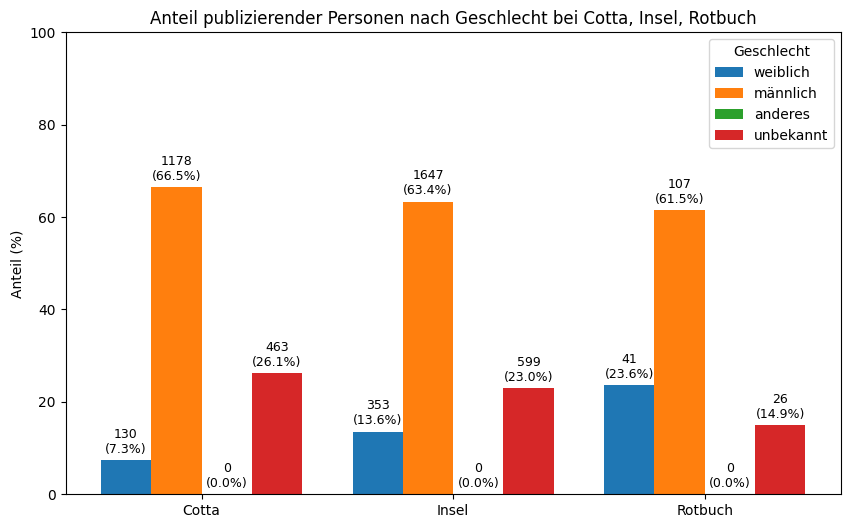

In [13]:
# Visualisierung mit Legende inkl. Werte
import numpy as np
labels = geschlechter
x = np.arange(len(author_ids))
width = 0.2
fig, ax = plt.subplots(figsize=(10,6))
for i, g in enumerate(labels):
    werte_abs = [int(round(anteile[v][g] * len(author_ids[v]) / 100)) if len(author_ids[v]) > 0 else 0 for v in author_ids]
    werte_pct = [anteile[v][g] for v in author_ids]
    bars = ax.bar(x + i*width, werte_pct, width, label=f"{g}")
    bar_labels = [f'{abs_val}\n({pct_val:.1f}%)' for abs_val, pct_val in zip(werte_abs, werte_pct)]
    ax.bar_label(bars, labels=bar_labels, padding=3, fontsize=9)
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(list(author_ids.keys()))
ax.set_ylabel('Anteil (%)')
ax.set_title('Anteil publizierender Personen nach Geschlecht bei Cotta, Insel, Rotbuch')
ax.legend(title='Geschlecht')
plt.ylim(0, 100)
plt.show()

## Herleitung mit Beispieldatensätzen

Liste der verfügbaren Felder: https://github.com/dla-marbach/dla-opac-transform/blob/main/docs/internformat.csv

Das Feld `publisher_display_mv` eignet sich, um die Publikationen der jeweiligen Verlage (Cotta, Insel, Rotbuch) zu ermitteln.

In [7]:
# Beispielabfrage für Verlag Rotbuch (1 Treffer)
url = "https://dataservice.dla-marbach.de/v1/records"
params = {
    "q": "publisher_display_mv:Rotbuch",
    "size": 1
}
response = requests.get(url, params=params)
print(response.text)

[{
      "id":"AK00378348",
      "display":"Siegfrieden : Politik mit einem deutschen Mythos - 1. Aufl.",
      "category":"Bibliotheksdokumente",
      "categoryContent_mv":["Text"],
      "categoryMedia_mv":["Druckschrift"],
      "categoryMedium_mv":["Band"],
      "categorySub":"Einzelne Einheit / Stücktitel, Band",
      "categorySubSub":"Druckschrift",
      "classificationSubjectOther_mv":["Anonyma, Anonymes Werk, Deutsche Literatur bis 1449"],
      "classification_category_mv":["Kette Bibliothek","Kette Bibliothek","Kette Bibliothek"],
      "classification_display_mv":["S8.7.3.D Deutsche Literaturwissenschaft / Einzelne Themen, Probleme / Deutschland","S8.7.3.N Deutsche Literaturwissenschaft / Einzelne Themen, Probleme / Nibelungen","S10.1.13 Mittelalter / Einzelne anonyme Werke / Nibelungenlied (Heldenepos : 1180-1210)"],
      "classification_id_mv":["SE00003310","SE00045579","SE00031027"],
      "contributor_display_mv":["Storch, Wolfgang"],
      "contributor_id_mv":["PE

Im Beispieldatensatz https://dataservice.dla-marbach.de/v1/records?q=id:AK01038365 ist keine Angabe des Geschlechts der Personen enthalten. Die Angabe findet sich im Feld `gender` der separaten Personendatensätze. Die Verknüpfung erfolgt über das Feld `personBy_id_mv`.

Im Beispieldatensatz gibt es zwei Personen:
```json
      "personBy_creator_mv":["creator","contributor"],
      "personBy_display_mv":["Wille, Carl (1961)","Forner, Rebecca"],
      "personBy_id_mv":["PE00046601","PE00445601"],
      "personBy_role_mv":["Verfasser/Urheber","Widmungsempfänger"],
```

Für die Fragestellung "publizierende Frauen" muss nach `personBy_role_mv` gefiltert werden. "Widmungsempfänger" sollte nicht mitgezählt werden. Die Felder personBy_id_mv und personBy_role_mv sind synchron belegt (gleicher Index).

In [8]:
# Alle Werte im Feld personBy_role_mv ermitteln und zählen am Beispiel des Verlags Rotbuch
from collections import Counter
url = "https://dataservice.dla-marbach.de/v1/records"
params = {
    "q": "publisher_display_mv:Rotbuch",
    "fields": "personBy_role_mv"
}
response = requests.get(url, params=params)
data = response.json()

rollen_counter = Counter()
for item in data:
    if "personBy_role_mv" in item:
        rollen_counter.update(item["personBy_role_mv"])

for rolle, anzahl in rollen_counter.most_common():
    print(f"{rolle}: {anzahl}")

Verfasser/Urheber: 357
Übersetzer: 50
Herausgeber: 42
Verfasser: 25
Widmungsempfänger: 20
Verfasser eines Nachworts: 14
Illustrator: 8
Interviewter: 5
Interviewer: 5
Verfasser eines Vorworts: 5
Bearbeiter: 4
Fotograf: 1
Mitarbeiter: 1
Librettist: 1


Für die Analyse werden nur Personen mit der Rolle "Verfasser/Urheber" oder "Verfasser" gezählt.

In [9]:
# Beispielabfrage für Verlag Rotbuch mit reduzierten Feldern (5 Treffer)
url = "https://dataservice.dla-marbach.de/v1/records"
params = {
    "q": "publisher_display_mv:Rotbuch",
    "fields": "publisher_display_mv,personBy_id_mv,personBy_role_mv",
    "size": 5
}
response = requests.get(url, params=params)
print(response.text)

[{
      "personBy_id_mv":["PE00080811","PE00000847"],
      "personBy_role_mv":["Verfasser/Urheber","Verfasser"],
      "publisher_display_mv":["Rotbuch-Verl."]
    },{
      "personBy_id_mv":["PE00002281","PE00496373"],
      "personBy_role_mv":["Interviewter","Interviewer"],
      "publisher_display_mv":["Rotbuch-Verl."]
    },{
      "personBy_id_mv":["PE00040082"],
      "personBy_role_mv":["Verfasser/Urheber"],
      "publisher_display_mv":["Rotbuch-Verl."]
    },{
      "personBy_id_mv":["PE00001142","PE00198953","PE00005449"],
      "personBy_role_mv":["Verfasser/Urheber","Herausgeber","Verfasser eines Vorworts"],
      "publisher_display_mv":["Rotbuch-Verl."]
    },{
      "personBy_id_mv":["PE00045163"],
      "personBy_role_mv":["Verfasser/Urheber"],
      "publisher_display_mv":["Rotbuch-Verl."]
    }]


Die Angabe des Geschlechts wird aus den Personendatensätzen ermittelt. Es gibt zwei Wege:

* A) IDs aus `personBy_id_mv` sammeln und einzeln abfragen
* B) Alle Personendatensätze herunterladen und lokal filtern

Hier wird Weg B gewählt.

In [10]:
# Beispielabfrage für Personendatensätze reduziert auf Felder id und gender (5 Treffer)
url = "https://dataservice.dla-marbach.de/v1/records"
params = {
    "q": "id:PE*",
    "fields": "id,gender",
    "size": 5
}
response = requests.get(url, params=params)
print(response.text)

[{
      "id":"PE00201113"
    },{
      "gender":"männlich",
      "id":"PE00201114"
    },{
      "gender":"männlich",
      "id":"PE00201116"
    },{
      "gender":"weiblich",
      "id":"PE00201117"
    },{
      "id":"PE00201119"
    }]


Die Werte im Feld `gender` sollten geprüft werden, um die spätere Aggregation zu erleichtern.

In [11]:
# Alle Werte im Feld gender ermitteln und zählen
from collections import Counter
url = "https://dataservice.dla-marbach.de/v1/records"
params = {
    "q": "id:PE* AND gender:*",
    "fields": "gender"
}
response = requests.get(url, params=params)
data = response.json()

gender_counter = Counter()
for item in data:
    if "gender" in item:
        gender_counter.update([item["gender"]])

for gender, anzahl in gender_counter.most_common():
    print(f"{gender}: {anzahl}")

männlich: 133649
weiblich: 48612
anderes: 24
